In [2]:
import torch
import random
import torch.nn as nn
from torch import optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import random_split
from torchmetrics.classification import MulticlassAccuracy


device = ("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
transform_train = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

transform_test = transforms.Compose(
    [
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

train_set_full = datasets.MNIST('data/MNIST/', download=True, train=True, transform=transform_train)
test_set = datasets.MNIST('data/MNIST/', download=True, train=False, transform=transform_test)

train_size = int(0.8 * len(train_set_full))
val_size = len(train_set_full) - train_size
train_set, val_set = random_split(train_set_full, [train_size, val_size])

print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Test samples: {len(test_set)}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

Training samples: 48000
Validation samples: 12000
Test samples: 10000


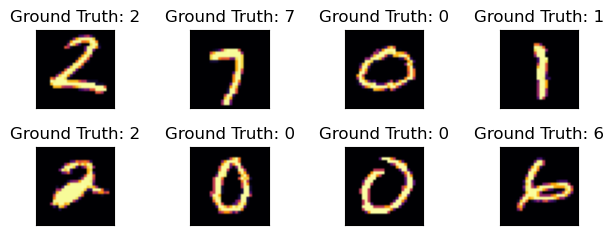

In [6]:
batch_idx, (images, labels) = next(enumerate(train_loader))
fig = plt.figure()
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title(f"Ground Truth: {labels[i].item()}")
    plt.xticks([]); plt.yticks([])
plt.show()

In [11]:
class MNISTV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 7 * 7, output_shape)
        )

    def forward(self, x):
        x = self.classifier(self.block_2(self.block_1(x)))
        return x

model_0 = MNISTV0(input_shape=1, hidden_units=32, output_shape=10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(), lr=0.001)
accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)

In [28]:
class ResidualBlockV0(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlockV0, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # If input and output dimensions differ, adjust the skip connection
        if in_channels != out_channels or stride != 1:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return F.relu(out)

In [29]:
class MNISTV1(nn.Module):
    def __init__(self, input_shape=1, hidden_units=32, output_shape=10):
        super().__init__()
        self.conv1 = nn.Conv2d(input_shape, hidden_units, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(hidden_units)
        
        # ResNet blocks
        self.res_block1 = ResidualBlockV0(hidden_units, hidden_units)
        self.res_block2 = ResidualBlockV0(hidden_units, hidden_units * 2, stride=2)
        self.res_block3 = ResidualBlockV0(hidden_units * 2, hidden_units * 2)
        
        # Classifier with dropout (regularization)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5), 
            nn.Linear(hidden_units * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_shape)
        )
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

In [25]:
def train_model(model, train_loader, val_loader, epochs=10):
    # L2 regularization through weight_decay
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    loss_fn = nn.CrossEntropyLoss()
    accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_acc = 0.0, 0.0
        
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy_fn(y_pred, y).item()
        
        model.eval()
        val_loss, val_acc = 0.0, 0.0
        
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = loss_fn(y_pred, y)
                
                val_loss += loss.item()
                val_acc += accuracy_fn(y_pred, y).item()
        
        train_loss /= len(train_loader)
        train_acc = 100 * train_acc / len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * val_acc / len(val_loader)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        # Update learning rate
        scheduler.step()
        current_lr = scheduler.get_last_lr()[0]
        
        print(f"Epoch [{epoch+1}/{epochs}] - LR: {current_lr:.6f}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print("-" * 50)
    
    return train_losses, train_accs, val_losses, val_accs

In [21]:
def plot_learning_curves(train_losses, train_accs, val_losses, val_accs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Training Accuracy', color='blue')
    ax2.plot(val_accs, label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [22]:
def test_model(model, test_loader):
    model.eval()
    test_loss, test_acc = 0.0, 0.0
    loss_fn = nn.CrossEntropyLoss()
    accuracy_fn = MulticlassAccuracy(num_classes=10).to(device)
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            test_acc += accuracy_fn(y_pred, y).item()
    
    test_loss /= len(test_loader)
    test_acc = 100 * test_acc / len(test_loader)
    
    print(f"\nFinal Test Results:")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    return test_loss, test_acc

In [26]:
def compare_models():
    print("Training Original Model...")
    original_model = MNISTV0(input_shape=1, hidden_units=32, output_shape=10).to(device)
    orig_train_losses, orig_train_accs, orig_val_losses, orig_val_accs = train_model(
        original_model, train_loader, val_loader, epochs=10
    )
    
    print("\n" + "="*60)
    print("Training Improved ResNet Model...")
    improved_model = MNISTV1(input_shape=1, hidden_units=32, output_shape=10).to(device)
    imp_train_losses, imp_train_accs, imp_val_losses, imp_val_accs = train_model(
        improved_model, train_loader, val_loader, epochs=10
    )
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    ax1.plot(orig_train_losses, label='Train', color='blue')
    ax1.plot(orig_val_losses, label='Val', color='red')
    ax1.set_title('Original Model - Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(orig_train_accs, label='Train', color='blue')
    ax2.plot(orig_val_accs, label='Val', color='red')
    ax2.set_title('Original Model - Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    ax3.plot(imp_train_losses, label='Train', color='blue')
    ax3.plot(imp_val_losses, label='Val', color='red')
    ax3.set_title('Improved ResNet Model - Loss')
    ax3.legend()
    ax3.grid(True)
    
    ax4.plot(imp_train_accs, label='Train', color='blue')
    ax4.plot(imp_val_accs, label='Val', color='red')
    ax4.set_title('Improved ResNet Model - Accuracy')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTesting Original Model:")
    test_model(original_model, test_loader)
    
    print("\nTesting Improved Model:")
    test_model(improved_model, test_loader)

Training Original Model...
Epoch [1/10] - LR: 0.001000
Train Loss: 0.1805, Train Acc: 94.22%
Val Loss: 0.0712, Val Acc: 97.79%
--------------------------------------------------
Epoch [2/10] - LR: 0.001000
Train Loss: 0.0633, Train Acc: 98.03%
Val Loss: 0.0595, Val Acc: 98.27%
--------------------------------------------------
Epoch [3/10] - LR: 0.001000
Train Loss: 0.0477, Train Acc: 98.45%
Val Loss: 0.0572, Val Acc: 98.33%
--------------------------------------------------
Epoch [4/10] - LR: 0.001000
Train Loss: 0.0395, Train Acc: 98.70%
Val Loss: 0.0447, Val Acc: 98.68%
--------------------------------------------------
Epoch [5/10] - LR: 0.000500
Train Loss: 0.0346, Train Acc: 98.85%
Val Loss: 0.0454, Val Acc: 98.62%
--------------------------------------------------
Epoch [6/10] - LR: 0.000500
Train Loss: 0.0214, Train Acc: 99.33%
Val Loss: 0.0351, Val Acc: 99.01%
--------------------------------------------------
Epoch [7/10] - LR: 0.000500
Train Loss: 0.0211, Train Acc: 99.30%
V

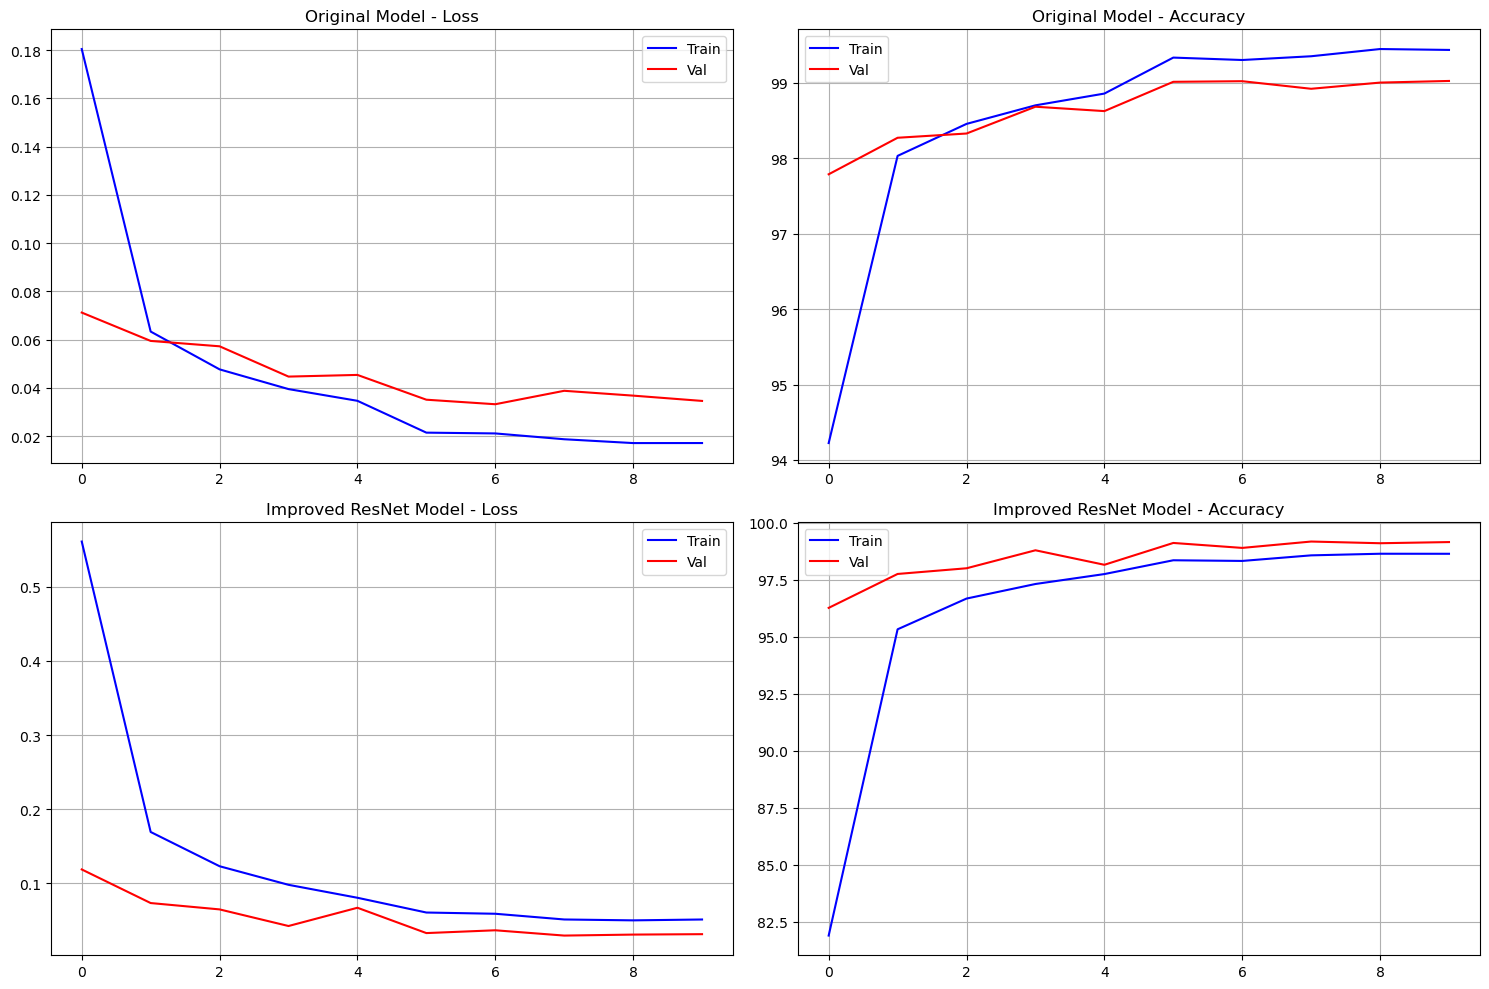


Testing Original Model:

Final Test Results:
Test Loss: 0.0297, Test Accuracy: 99.08%

Testing Improved Model:

Final Test Results:
Test Loss: 0.0221, Test Accuracy: 99.30%


In [30]:
if __name__ == "__main__":
    compare_models()